In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pathlib import Path


plt.style.use("default")
plt.rcParams.update({
    #"text.usetex": False,
    #"font.family": "serif",
    #"font.serif": ["Helvetica"],
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})

DATA_SOURCE = Path.cwd() / 'data' / 'input' / 'raw'
PROC_SOURCE = DATA_SOURCE.parent / "processed"

def get_bh_integral(df):
    b, h = df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), df.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()
    h += 100
    return df.freq * 0.5*np.abs(np.sum(b * (np.roll(h, 1, axis=1) - np.roll(h, -1, axis=1)) , axis=1))  # shoelace formula

In [82]:
ds = pd.read_pickle(PROC_SOURCE / "ten_materials.pkl.gz")
full_b, full_h = ds.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), ds.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()

<class 'numpy.ndarray'>
(186747, 1024)
[ 5.43285344e-04  7.37512741e-04  9.31392335e-04 ... -3.80581747e-05
  1.55395461e-04  3.49027740e-04]


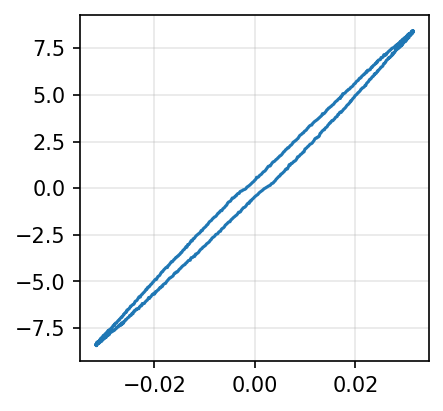

In [ ]:
print(type(full_b))
print(full_b.shape)
print(full_b[0])
plt.figure(dpi=150, figsize=(3,3))
plt.plot(full_b[0], full_h[0])

In [ ]:
materials = ds.loc[:, ["material"]]["material"].unique()
print(f"Materials: {materials}")
frequencies = sorted(list(ds.loc[(ds["material"] == 'N49') & (ds["temp"] == 25)]["freq"].unique()))
print(f"Frequencies: {frequencies}")

ploss = ds.loc[(ds["material"] == 'N49') & (ds["temp"] == 25)]["ploss"].to_numpy()
b_max = ds.loc[(ds["material"] == 'N49') & (ds["temp"] == 25)][[f"B_t_{k}" for k in range(0,1024, 4)]].to_numpy().max(1)

#plt.scatter(b_max, ploss)


ploss = ds.loc[(ds["material"] == 'N49') & (ds["temp"] == 25)]["ploss"].to_numpy()
freq = ds.loc[(ds["material"] == 'N49') & (ds["temp"] == 25)]["freq"].to_numpy()

#plt.scatter(freq, ploss)

Materials: ['3C90' '3C94' '3E6' '3F4' '77' '78' 'N27' 'N30' 'N49' 'N87']
Frequencies: [49950.0, 49960.0, 49970.0, 49980.0, 49989.9999999999, 50000.0, 50009.9999999999, 50020.0, 50040.0, 50049.9999999999, 50059.9999999999, 50069.9999999999, 50080.0, 50090.0, 50099.9999999999, 50129.9999999999, 50140.0000000001, 50150.0000000001, 50159.9999999999, 63010.0000000002, 63019.9999999998, 63030.0000000001, 63040.0000000002, 63060.0000000001, 63080.0000000001, 63090.0, 63100.0, 63110.0, 63120.0000000001, 63130.0000000002, 63140.0, 63150.0000000002, 63160.0000000001, 63170.0, 63180.0, 63190.0, 63209.9999999999, 63220.0000000001, 63229.9999999999, 79410.0000000002, 79420.0000000003, 79430.0000000002, 79439.9999999997, 79449.9999999997, 79460.0000000002, 79469.9999999999, 79480.0000000003, 79489.9999999998, 79500.0000000003, 79509.9999999997, 79519.9999999997, 79529.9999999999, 99900.0, 99910.0, 99920.0, 99930.0, 99940.0, 99950.0, 99960.0, 99970.0, 99980.0, 99990.0, 100000.0, 100010.0, 100020.0, 1

In [ ]:
def steinmetz(freq, b_max, alpha, beta, k):
    return k*freq**alpha*b_max**beta

In [ ]:
init_alpha = 1.42
init_beta = 2.6
init_k = 2

# estimated_loss = np.array(len(freq))
def estimated_loss(alpha, beta, k):
    return steinmetz(freq, b_max, alpha, beta, k)

def normalized_error(alpha, beta, k):
    return np.mean(abs((estimated_loss(alpha, beta, k)-ploss)/ploss))


normalized_error(init_alpha, init_beta, init_k)
#plt.scatter(freq, estimated_loss)
#plt.scatter(freq, ploss)
#plt.scatter(freq, (estimated_loss-ploss)/ploss)
#plt.show()

0.327250837849751

In [ ]:
import optuna

def objective(trial):
    aa = trial.suggest_float('aa', 1, 3)
    bb = trial.suggest_float('bb', 2., 4)
    kk = trial.suggest_float('kk', 0.1, 100)
    return normalized_error(aa, bb, kk)

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}

[I 2023-05-26 10:42:47,348] A new study created in memory with name: no-name-f6312ced-2319-403d-b6d2-9dd5474819f6
[I 2023-05-26 10:42:47,352] Trial 0 finished with value: 167132693.35040683 and parameters: {'aa': 2.820267795280486, 'bb': 3.396619398102911, 'kk': 95.84356599661932}. Best is trial 0 with value: 167132693.35040683.
[I 2023-05-26 10:42:47,353] Trial 1 finished with value: 959216.1156225101 and parameters: {'aa': 2.527432475468686, 'bb': 3.938873304067723, 'kk': 75.76959723541464}. Best is trial 1 with value: 959216.1156225101.
[I 2023-05-26 10:42:47,355] Trial 2 finished with value: 236.4770157557742 and parameters: {'aa': 1.8466994404453745, 'bb': 3.9530776913207237, 'kk': 80.77259872173215}. Best is trial 2 with value: 236.4770157557742.
[I 2023-05-26 10:42:47,356] Trial 3 finished with value: 832.0364476771292 and parameters: {'aa': 1.7841285001181222, 'bb': 3.10465420691035, 'kk': 90.96884820548547}. Best is trial 2 with value: 236.4770157557742.
[I 2023-05-26 10:42:47

{'aa': 1.2555917540499417, 'bb': 3.2063467878946152, 'kk': 77.51193730822834}

In [86]:
#fig = optuna.visualization.plot_optimization_history(study)
#fig.show()

import plotly.express as px
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

C:\Users\tpiepe\AppData\Local\Temp\ipykernel_17092\1813867825.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('plasma')


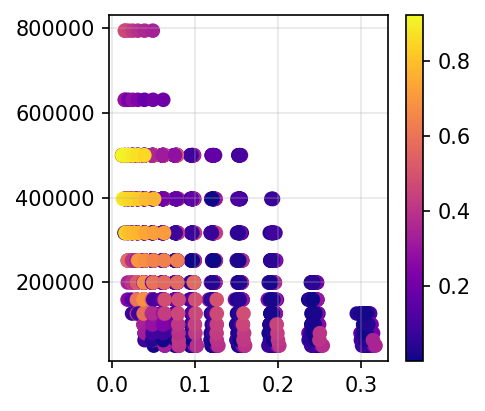

In [ ]:
error_norm = (estimated_loss(study.best_params["aa"],study.best_params["bb"],study.best_params["kk"]) -ploss)/ploss


# 1D error plots
#plt.scatter(b_max, error_norm)
#plt.scatter(freq, error_norm)


# 2D error plots
plt.figure(dpi=150, figsize=(3,3))
cm = plt.cm.get_cmap('plasma')
xy = range(20)
sc = plt.scatter(b_max, freq, c=abs(error_norm), vmin=None, vmax=None, s=None, cmap=cm)
plt.colorbar(sc)

plt.show()